# Within Blocks Analysis
By: Adam Li

Here I analyze the differences between same word pair, reversed and different word pair in the same block.

In [9]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools

from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [10]:
######## Load in EVENTS struct to find correct events
eventsDir = '../NIH034/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# print number of incorrect events and which words they belonged to
incorrectIndices = events['isCorrect'] == 0
incorrectEvents = events[incorrectIndices]
incorrectWords = []
wordList = {}
for i in range(0, len(incorrectEvents)):
    incorrectWords.append(incorrectEvents['probeWord'][i][0])

for word in np.unique(incorrectEvents['probeWord']):
    wordList[str(word)] = sum(incorrectWords == word)
    
print "There were ",len(incorrectEvents), " number of incorrect events."
print "The list of incorrect probe words: \n", wordList
# 
# get only correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "\nThis is the length of the events struct with only correct responses: ", len(events)

There were  49  number of incorrect events.
The list of incorrect probe words: 
{"[u'PANTS']": 7, "[u'JUICE']": 8, "[u'BRICK']": 12, "[u'CLOCK']": 13, "[u'GLASS']": 9}

This is the length of the events struct with only correct responses:  1431


## Looking at Each Session Within Block Analysis

1. Get data structure of same groups, reverse groups, and different groups
2. For each group plot pairwise histogram of feature distances

In [20]:
##### HYPER-PARAMETERS TO TUNE
anova_threshold = 90   # how many channels we want to keep
distances = Distance.cosine # define distance metric to use
num_time_windows = 5
freq_bands = [0, 1, 6]
freq_bands = np.arange(0,7,1)

freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
print freq_bands
print [freq_labels[i] for i in freq_bands]

print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands)

[0 1 2 3 4 5 6]
['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']
The length of the feature vector for each channel will be:  35


In [21]:
### Functions to help extract features and plot histogram of distances
# loops through each wordpairing group and extract features
def extractFeatures(wordgroup, session, block, block_dir):
    PairFeatureDict = {}
    for idx, pairs in enumerate(wordgroup):
        # load in data
        first_wordpair_dir = block_dir + '/' + pairs[0]
        second_wordpair_dir = block_dir + '/' + pairs[1]

        # initialize np arrays for holding feature vectors for each event
        first_pair_features = []
        second_pair_features = []

        # load in channels for each 
        channels = os.listdir(first_wordpair_dir)
        # loop through channels
        for jdx, chans in enumerate(channels):
            # Each wordpair's fullfile dir path
            first_chan_file = first_wordpair_dir + '/' + chans
            second_chan_file = second_wordpair_dir + '/' + chans

            ## 0: load in data
            data_first = scipy.io.loadmat(first_chan_file)
            data_first = data_first['data']
            data_second = scipy.io.loadmat(second_chan_file)
            data_second = data_second['data']

            ## 01: get the time point for probeword on
            first_timeZero = data_first['timeZero'][0][0][0]
            second_timeZero = data_second['timeZero'][0][0][0]

            ## 02: get the time point of vocalization
            first_vocalization = data_first['vocalization'][0][0][0]
            second_vocalization = data_second['vocalization'][0][0][0]

            ## 03: Get Power Matrix
            first_matrix = data_first['powerMatZ'][0][0]
            second_matrix = data_second['powerMatZ'][0][0]
            first_matrix = first_matrix[:, freq_bands,:]
            second_matrix = second_matrix[:, freq_bands,:]

            ### 1: get only the time point before vocalization
            first_mean = []
            second_mean = []
            for i in range(0, len(first_vocalization)):
                # either go from timezero -> vocalization, or some other timewindow
                first_mean.append(np.mean(first_matrix[i,:,first_timeZero:first_vocalization[i]], axis=1))
#                     first_mean.append(np.ndarray.flatten(first_matrix[i,:,first_vocalization[i]-num_time_windows:first_vocalization[i]]))
            for i in range(0, len(second_vocalization)):
                second_mean.append(np.mean(second_matrix[i,:,second_timeZero:second_vocalization[i]], axis=1))
#                     second_mean.append(np.ndarray.flatten(second_matrix[i,:,second_vocalization[i]-num_time_windows:second_vocalization[i]]))

            # create feature vector for each event
            if jdx == 0:
                first_pair_features.append(first_mean)
                second_pair_features.append(second_mean)
                first_pair_features = np.squeeze(np.array(first_pair_features))
                second_pair_features = np.squeeze(np.array(second_pair_features))
            else:
                first_pair_features = np.concatenate((first_pair_features, first_mean), axis=1)
                second_pair_features = np.concatenate((second_pair_features, second_mean), axis=1)
        # end of loop through channels
        
        # should be #events X #features (channels x freq. bands x time points)
        if idx==0:
            print first_pair_features.shape
            print second_pair_features.shape
        
        # add to overall dictionary for each comparison word for return statement at end
        pairName = pairs[0] + 'vs' + pairs[1]
        PairFeatureDict[pairName] = []
        PairFeatureDict[pairName].append(first_pair_features)
        PairFeatureDict[pairName].append(second_pair_features)
        
    return PairFeatureDict
 
def computePairDistances(first_mat, second_mat):
    distance_list = []

    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
#     for idx in range(0, second_mat.shape[0]):
#         distance_list.append([distances(x, second_mat[idx,:]) for x in first_mat])
        
    distance_list = np.ndarray.flatten(np.array(distance_list))

    return distance_list    

Analyzing session  session_1
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']
[['BRICK_CLOCK', 'BRICK_CLOCK'], ['CLOCK_BRICK', 'CLOCK_BRICK'], ['GLASS_JUICE', 'GLASS_JUICE'], ['JUICE_GLASS', 'JUICE_GLASS']]
[['BRICK_CLOCK', 'CLOCK_BRICK'], ['GLASS_JUICE', 'JUICE_GLASS']]
[['BRICK_CLOCK', 'GLASS_JUICE'], ['BRICK_CLOCK', 'JUICE_GLASS']]
(20, 672)
(20, 672)
(20, 672)
(20, 672)
(20, 672)
(20, 672)
Done
Analyzing  JUICE_GLASSvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsBRICK_CLOCK
Analyzing  GLASS_JUICEvsGLASS_JUICE
Analyzing  CLOCK_BRICKvsCLOCK_BRICK
Analyzing  GLASS_JUICEvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsCLOCK_BRICK
Analyzing  CLOCK_BRICKvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsJUICE_GLASS
Analyzing  CLOCK_BRICKvsGLASS_JUICE
Analyzing  BRICK_CLOCKvsGLASS_JUICE


/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


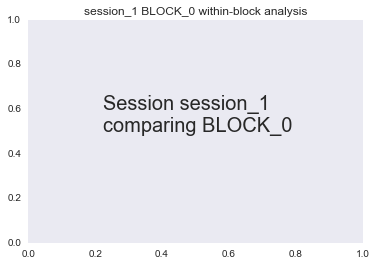

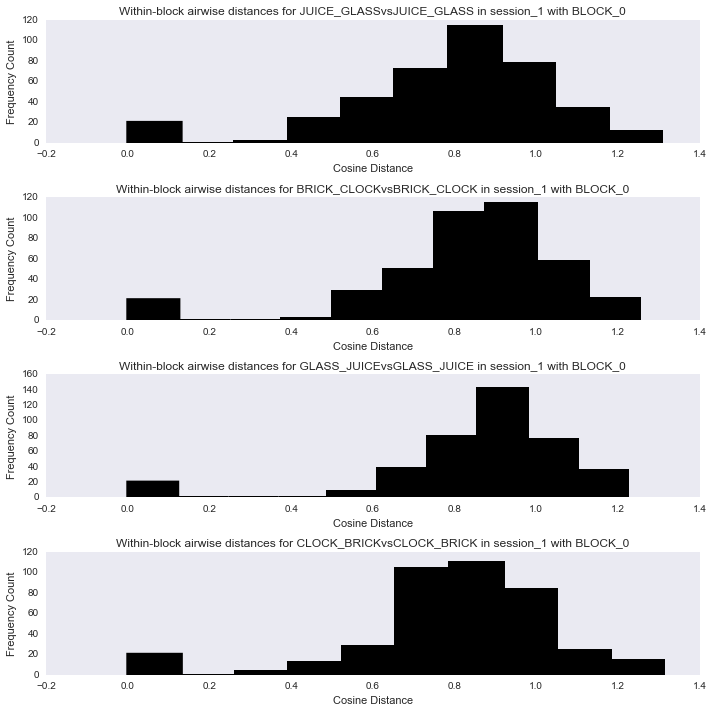

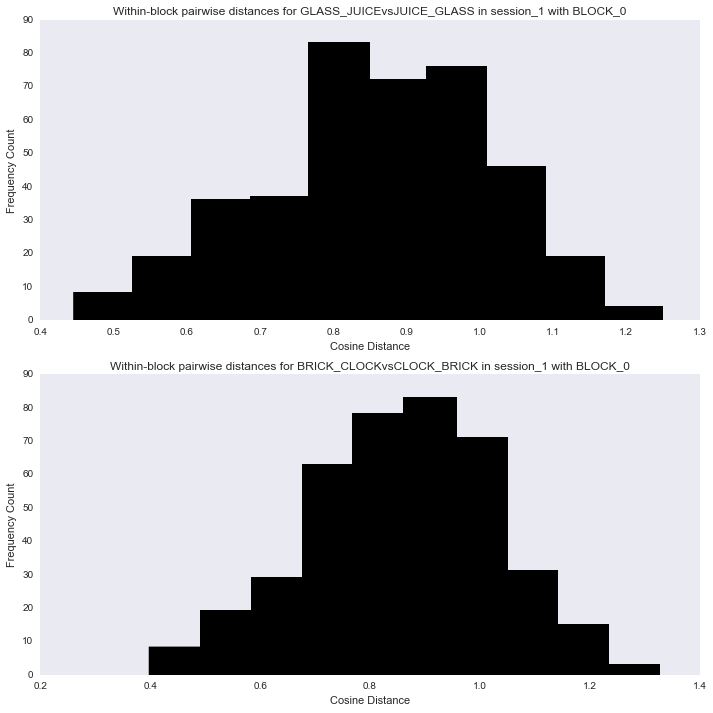

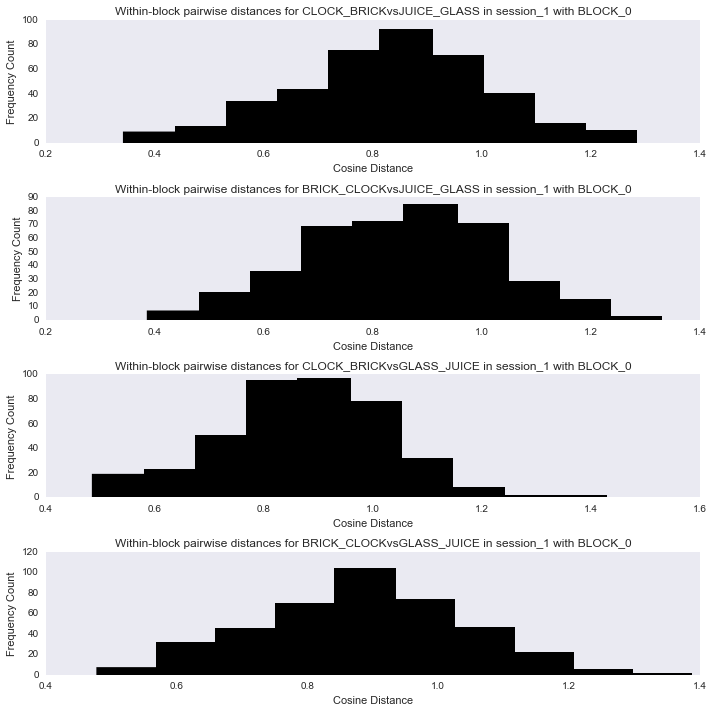

In [22]:
def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 5):
        print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        print "These are the wordpairs in this block: ", wordpairs
         
   
        #### plot meta information about which session and blocks we're analyzing
        fig=plt.figure()
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s %scomparing %s'%(session, '\n',block), fontsize=20)
        plt.title(session + ' ' + block + ' within-block analysis')
        plt.grid(False)
        
        ## 01: Create WordPair Groups
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])

        # debugging check
        print same_word_group
        print reverse_word_group
        print diff_word_group[0:2]
        
        ### Go through each group and extract the feature data for each wordpair comparison
        same_feature_dict = extractFeatures(same_word_group,session,block,block_dir)
        reverse_feature_dict = extractFeatures(reverse_word_group,session,block,block_dir)
        diff_feature_dict = extractFeatures(diff_word_group,session,block,block_dir)
        
        print 'Done'
        
        fig = plt.figure(figsize=(10,10))
        for idx, comp in enumerate(same_feature_dict.keys()):
            distance_hist = computePairDistances(same_feature_dict[comp][0], same_feature_dict[comp][1])
            print "Analyzing ", comp
            
            sub = plt.subplot(len(same_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Distance')
            plt.ylabel('Frequency Count')
            plt.title('Within-block airwise distances for ' + comp + ' in ' + session + ' with ' + block)
        plt.tight_layout()
            
        fig = plt.figure(figsize=(10,10))
        for idx, comp in enumerate(reverse_feature_dict.keys()):
            distance_hist = computePairDistances(reverse_feature_dict[comp][0], reverse_feature_dict[comp][1])
            print "Analyzing ", comp
            
            sub = plt.subplot(len(reverse_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Distance')
            plt.ylabel('Frequency Count')
            plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' with ' + block)
        plt.tight_layout()
            
        fig = plt.figure(figsize=(10,10))
        for idx, comp in enumerate(diff_feature_dict.keys()):
            distance_hist = computePairDistances(diff_feature_dict[comp][0], diff_feature_dict[comp][1])
            print "Analyzing ", comp
            
            sub = plt.subplot(len(diff_feature_dict.keys()), 1, idx+1)
            ax = plt.gca()
            ax.grid(False)
            plt.hist(distance_hist, color='k', lw=3)
            plt.xlabel('Cosine Distance')
            plt.ylabel('Frequency Count')
            plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' with ' + block)
        plt.tight_layout()
        
        break # look at 1 block
    break # look at 1 session

Analyzing  JUICE_GLASSvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsBRICK_CLOCK
Analyzing  GLASS_JUICEvsGLASS_JUICE
Analyzing  CLOCK_BRICKvsCLOCK_BRICK


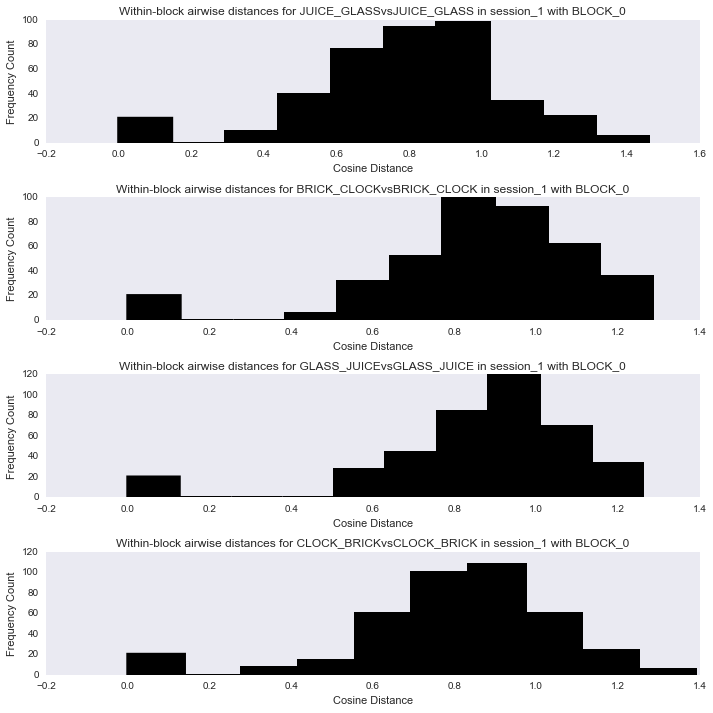

Analyzing  GLASS_JUICEvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsCLOCK_BRICK


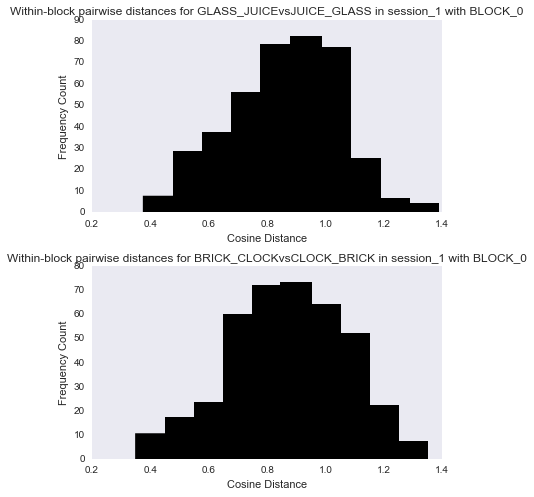

In [19]:
fig = plt.figure(figsize=(10,10))
for idx, comp in enumerate(same_feature_dict.keys()):
    distance_hist = computePairDistances(same_feature_dict[comp][0], same_feature_dict[comp][1])
    print "Analyzing ", comp

    sub = plt.subplot( len(same_feature_dict.keys()), 1,idx+1)
    ax = plt.gca()
    ax.grid(False)
    plt.hist(distance_hist, color='k', lw=3)
    plt.xlabel('Cosine Distance')
    plt.ylabel('Frequency Count')
    plt.title('Within-block airwise distances for ' + comp + ' in ' + session + ' with ' + block)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(7,7))
for idx, comp in enumerate(reverse_feature_dict.keys()):
    distance_hist = computePairDistances(reverse_feature_dict[comp][0], reverse_feature_dict[comp][1])
    print "Analyzing ", comp

    sub = plt.subplot(len(reverse_feature_dict.keys()), 1, idx+1)
    ax = plt.gca()
    ax.grid(False)
    plt.hist(distance_hist, color='k', lw=3)
    plt.xlabel('Cosine Distance')
    plt.ylabel('Frequency Count')
    plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' with ' + block)
plt.tight_layout()


Analyzing  CLOCK_BRICKvsJUICE_GLASS
Analyzing  BRICK_CLOCKvsJUICE_GLASS
Analyzing  CLOCK_BRICKvsGLASS_JUICE
Analyzing  BRICK_CLOCKvsGLASS_JUICE


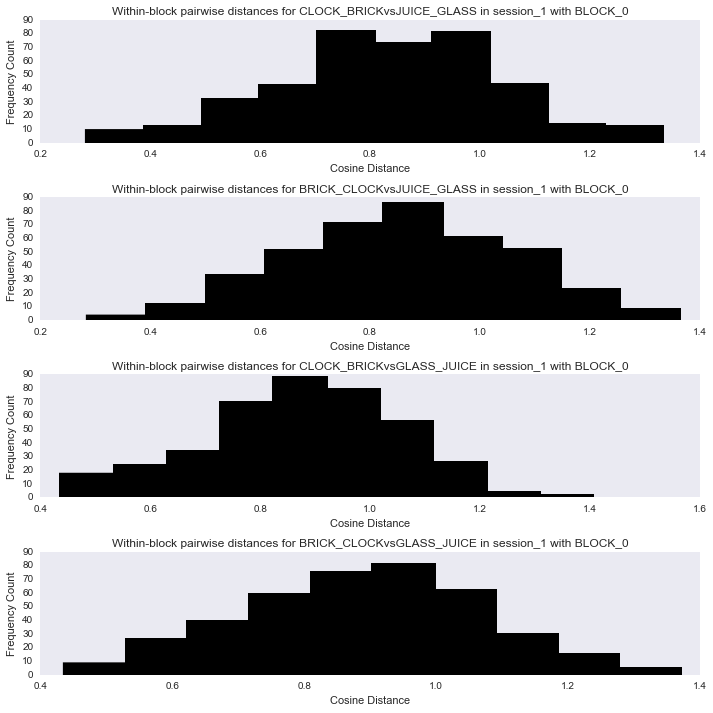

In [17]:
fig = plt.figure(figsize=(10,10))
for idx, comp in enumerate(diff_feature_dict.keys()):
    distance_hist = computePairDistances(diff_feature_dict[comp][0], diff_feature_dict[comp][1])
    print "Analyzing ", comp

    sub = plt.subplot(len(diff_feature_dict.keys()), 1, idx+1)
    ax = plt.gca()
    ax.grid(False)
    plt.hist(distance_hist, color='k', lw=3)
    plt.xlabel('Cosine Distance')
    plt.ylabel('Frequency Count')
    plt.title('Within-block pairwise distances for ' + comp + ' in ' + session + ' with ' + block)
plt.tight_layout()